# Basics of Mobile Robotics

## Table of Contents

* [Introduction](#chapter1)
    * [Framework](#section_1_1)
    * [Environment](#section_1_2)
    * [Modules](#section_1_3)
    * [Librairies](#section_1_4)

* [Computer Vision](#chapter2)
    * [Vision initialization and calibration](#section_2_1)
    * [Prepocessing](#section_2_1)
    * [Map initialization](Section_2_2)
        * [Obstacles Detection](#section_2_2_1)
        * [Goal Detection](#section_2_2_2)
        * [Thymio Detection](#section_2_2_3)
    * [Resize](Section_2_3)
* [Global Navigation](#chapter3)
    * [Occupancy Grid](#section_3_1)
    * [A* Algorithm](#section_3_2)
    
* [Kalman Filter](#chapter4)
    * [Prediction](#section_4_1)
    * [Update](#section_4_2)
   
* [Local Navigation](#chapter5)
    * [Local Avoidance](#section_5_1)
    * [Kidnapping](#section_5_2)
    
* [Overall Project](#chapter6)
    * [Overview](#section_6_1)
    
* [Conclusion](#chapter7)
* [Sources](#chapter8)

## 1. Introduction <a class="anchor" id="chapter1"></a>



### 1.1 Framework  <a class="anchor" id="section_1_1"></a>
First of all, we decided to make a framwork prior to start coding. We thought it would help us to manage better the project wuth the big picture, to have a better understanding of what needs to be done and take as early as possible smart decisions. For filtering we decided to use a Kalman filter who would filter the robot position and angle detected form vision. To improve it, whe decided to add the odometry of the motors to its input. At this stage, we had in mind to compensate for vision defect with odometry, which ends up being very succesful. The, we decided to make a grid base map. We thought it would be easy and convinient since the images from the camera are already in a grid based fashion with the pixels. It led us to use the A* algortihm for the path planning, which is easy to use, with good and accesible off-the-self ressources. The rest of the framework was then straightforward. 

![frame](image/framework.jpg)


### 1.2 Environment <a class="anchor" id="section_1_2"></a>

![frame](image/env.jpg)


### 1.3 Modules <a class="anchor" id="section_1_3"></a>

describe modules 

### 1.4 Librairies <a class="anchor" id="section_1_4"></a>



In [94]:
from VisionClass import VisionClass
from GlobalMapClass import GlobalMapClass
import ShorthestPath
from KalmanFilterClass import KalmanFilterClass
from LocalNavigator import LocalNavigator
import motionPlanning
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from tdmclient import ClientAsync, aw
from matplotlib import colors
import math

## 2. Computer Vision <a class="anchor" id="chapter2"></a>

### 2.1 Calibration <a class="anchor" id="section_2_1"></a>

We will detect the robot, goal by filtering a specific color out of an image with an HSV filer. 
For that, we manually calibrate the values of the HSV filter for goal and robot detection, as well as a threshold value to detect obstacles by using the keyboard. This allow us to adapt the values of the filters according to the environnment which is a robust way to detect objects with different lighting conditions. 

This gives us the calibrated image. 

In practice, this is the first thing we do when we open the webcam.

### 2.2 Map initialisation

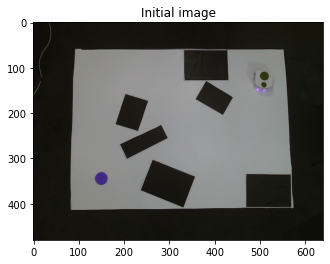

In [15]:
#read and plot image to analyse
image = cv2.imread('finalMap.png')
plt.title("Initial image")
plt.imshow(image)

We initialise our map in three steps:
* Robot detection
* Goal detection
* Obstacles detection

In order to detect this objects, we use the values detected manually previously for the HSV and the RGB mask as well as the threshold. 

#### 2.2.1 Robot detection

First we apply a blur filter on the image in order to smooth the image and ensure we do not detect unsignificant features in the image. 

Then, in order to detect the robot, we:
* Detect green (the colour of the robot), for that we have two possible filters : HSV or RGB, and we decide manually which one is better to use in this conditions if we do the handcalibration. Otherwise, we use the HSV filter to detect green because it is the one that fits the best most of the time.
Here we use the values founded manually when we took the picture.
* Detect circles : we must detect the two circles of the robot to know the position and set the direction of the robot.
In order to do that we find all the contours in the image using an openCV function and we select the contours big enough to correspond to the circles of the robot. (and to ensure we do not consider noise as a circle) 
* Finally, we compute the position and the direction of the robot thanks to the values found for the position of the two circles 

Robot position is: 510 118 1.6233793884058383


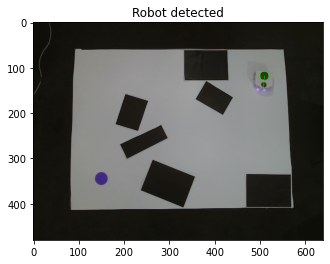

In [54]:
image_robot = image.copy()

Vision = VisionClass(False)
Vision.lowRobot = np.array([30, 50, 50])
Vision.highRobot = np.array([100, 255, 255])
Vision.HSVR = True
Vision.image = image_robot
Vision.imageDraw = image_robot

[robotPosX, robotPosY, theta] = Vision.robotDetection()

#Print the position
print("Robot position is:", robotPosX, robotPosY, theta)

#Plot the robot detected
plt.title("Robot detected")
plt.imshow(Vision.imageDraw)

#### 2.2.2 Goal detection

Here we detect the goal using the same process as above for the robot. 

This time we only have two steps :
* Detect red color : for the goal, by default we use a RGB filter which is more appropriate for the detection of the red. 
* Detect the circle, using the same function as above for the robot.

Goal position is: 150 344


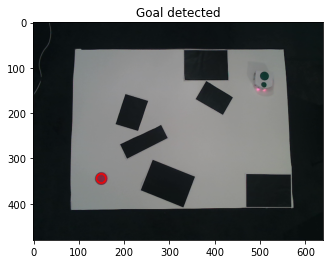

In [64]:
image_goal = image.copy()

Vision = VisionClass(False)
Vision.lowGoal = np.array([37, 14, 90])
Vision.highGoal = np.array([97, 74, 150])
Vision.HSVG = False
Vision.image = image_goal
Vision.imageDraw = image_goal

[goalPosX, goalPosY] = Vision.goalDetection()
Vision.imageDraw = cv2.cvtColor(Vision.imageDraw, cv2.COLOR_BGR2RGB)

#Print the position
print("Goal position is:", goalPosX, goalPosY)

#Plot the robot detected
plt.title("Goal detected")
plt.imshow(Vision.imageDraw)

#### 2.2.3 Obstacle detection


To detect the obstacles, we need to apply some filters on the image taken by the camera in order to have a good image to analyse.
First we need to pay attention to have a RGB image (convert the BGR image to a RGB image), then we apply :
* A Blur filter : a blur filter to prevent from detecting unsignificant features of the image using edge detection.
* A Bilateral filter : a bilateral filter to preserve edges while smoothing the image.
* A threshold to convert the map into a binary map 

We then use morphological operators :
* Erode to remove noise.
* Dilate the image such as the robot never touches the obstacles.

Finally, we go through each pixel of the binary map : if the pixel is black then the pixel is occupied ( = 1) otherwise, it is considered as free ( = 0) and the robot can pass through the case. 
This gives us the occupancy grid that the A* star will use to find the shortest path.

Here are the code of the processing of the image.

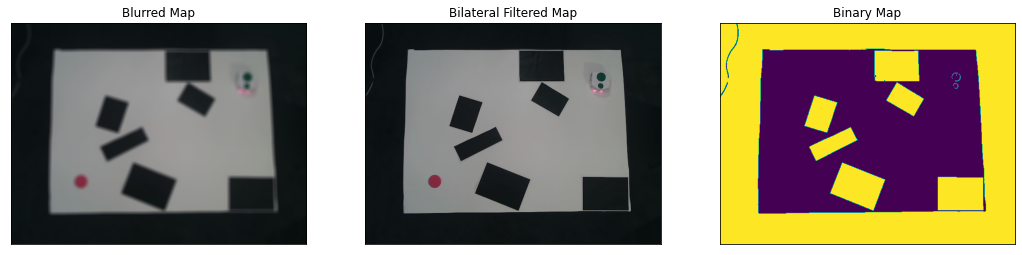

In [72]:
image_obstacles = image.copy()

# Convert to RGB
map_rgb = cv2.cvtColor(image_obstacles, cv2.COLOR_BGR2RGB)

# Blur Image
map_blur = cv2.blur(map_rgb,(10,10))

# Apply Bilateral filter
map_bilateral = cv2.bilateralFilter(map_rgb,5,15,15)

# Create Binary Image
map_gray = cv2.cvtColor(map_bilateral, cv2.COLOR_RGB2GRAY)
_, map_binary = cv2.threshold(map_gray, 40, 255, cv2.THRESH_BINARY_INV)

# Opening to remove noise
kernel_morph = np.ones((10,10),np.uint8)
map_clean = cv2.morphologyEx(map_binary, cv2.MORPH_OPEN, kernel_morph)

kernel_erode = np.ones((10,10),np.uint8) 
kernel_dilate = np.ones((70,70),np.uint8) 
map_occupancy = cv2.erode(map_clean, kernel_erode, iterations=1)
map_occupancy = cv2.dilate(map_occupancy, kernel_dilate, iterations=1)

plt.figure(figsize=(18,18))

plt.subplot(1,3,1),plt.imshow(map_blur)
plt.title("Blurred Map")
plt.xticks([]),plt.yticks([])

plt.subplot(1,3,2),plt.imshow(map_bilateral)
plt.title("Bilateral Filtered Map")
plt.xticks([]),plt.yticks([])

plt.subplot(1,3,3),plt.imshow(map_binary)
plt.title("Binary Map")
plt.xticks([]),plt.yticks([])
plt.show()

We can also just run the function "occupancy grid" which call the function detailed just above. 

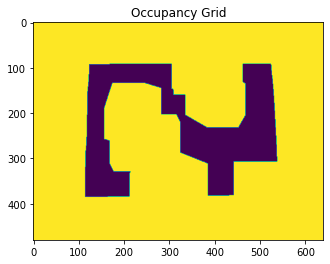

In [76]:
Vision.tresh = 40
occupancy_grid = Vision.obstaclesDetection(True)

#plot the occupancy grid
plt.title("Occupancy Grid")
plt.imshow(occupancy_grid)

#### 2.2.4 Conclusion

We can display the occupancy grid with the robot and the goal : 

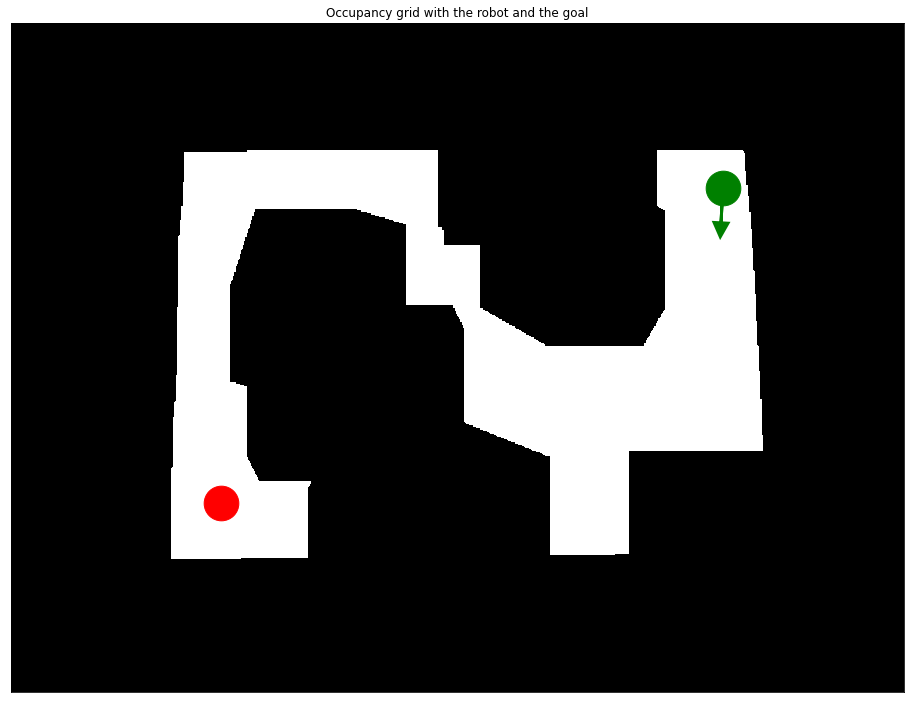

In [102]:
plt.figure(figsize=(16,16))
cmap = colors.ListedColormap(['white', 'black'])
plt.imshow(occupancy_grid, cmap=cmap)
plt.scatter(goalPosX, goalPosY, marker="o", color='red', s=1200);
plt.scatter(robotPosX, robotPosY, marker="o", color='green', s=1200);

plt.title("Occupancy grid with the robot and the goal")
plt.arrow(robotPosX, robotPosY, 25*math.cos(theta),
         25*math.sin(theta), head_width=10, head_length=10, fc='green', ec='green', lw=3)
axes = plt.xticks([]),plt.yticks([])

### 3. Global Navigation <a class="anchor" id="chapter3"></a>

#### 3.1 Occupancy Grid<a class="anchor" id="section_3_1"></a>

#### 3.2 A* Algorithm <a class="anchor" id="section_3_2"></a>


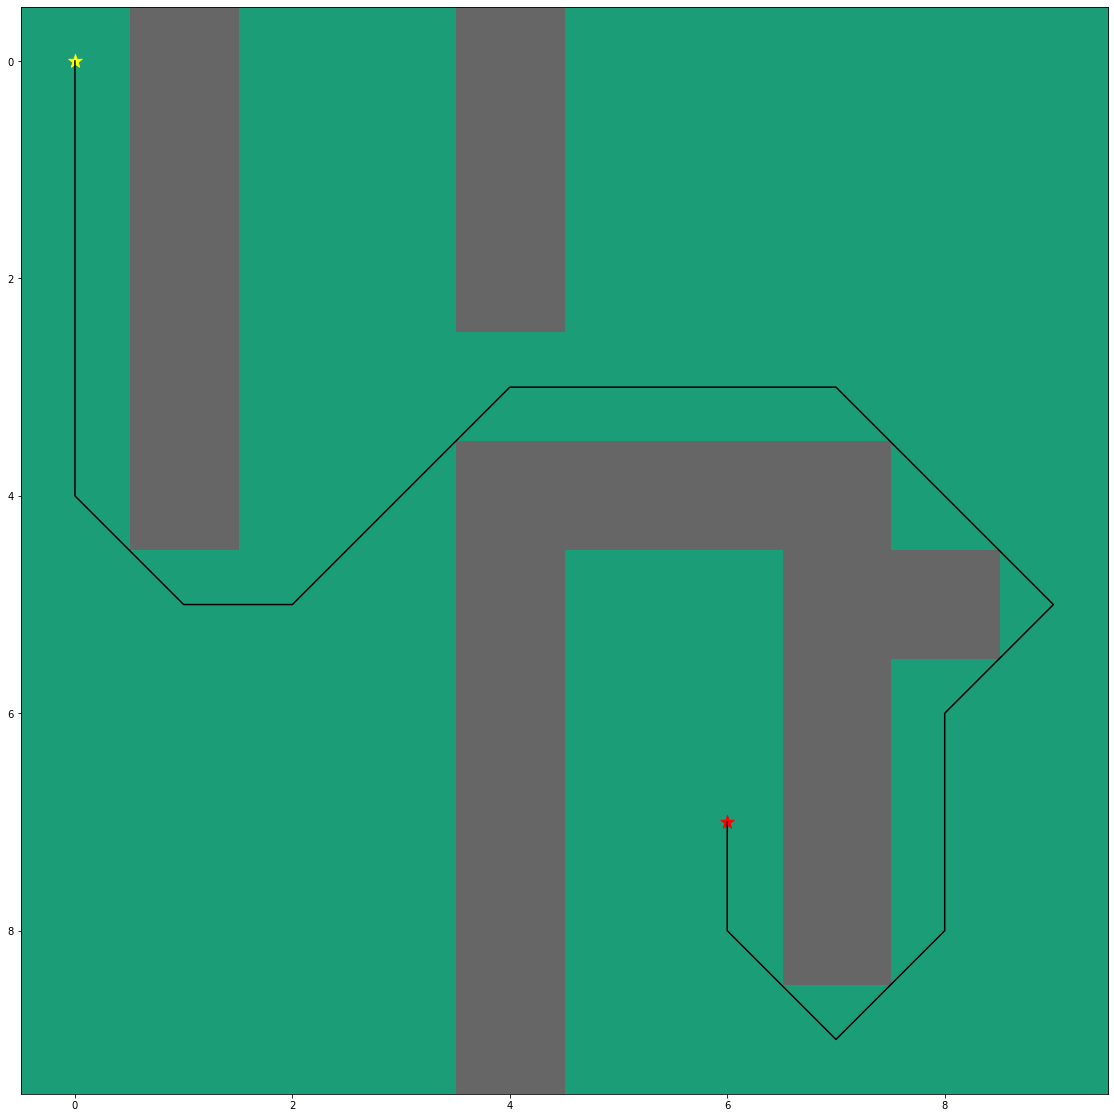

In [58]:
import ShorthestPath as sp

obstacleGrid = np.array([[0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                         [0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
                         [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
                         [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
                         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

start = (0, 0)
goal = (6, 7)
width = 10
height = 10

route = sp.astar(maze,height, width, start, goal)
route = route + [start]
#route = route[::-1]


# plot the path
#extract x and y coordinates from route list
x_coords = []
y_coords = []

for i in (range(0,len(route))):
    x = route[i][1]
    y = route[i][0]
    x_coords.append(x)
    y_coords.append(y)

# plot map and path
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(maze, cmap=plt.cm.Dark2)
ax.scatter(start[0],start[1], marker = "*", color = "yellow", s = 200)
ax.scatter(goal[0],goal[1], marker = "*", color = "red", s = 200)
ax.plot(y_coords,x_coords, color = "black")
plt.show()

### 4. Kalman Filter <a class="anchor" id="chapter4"></a>
We decided at the beginning of the project to use a Kalman filter, to filter the position and orientation of the robot in the map. The  measurement came from the camera, with the vision funtion visionObject.robotDetection(). In addition we used the odometry of the robot to improve our Kalman prediction. This structure gives fairly good results, and we the camera can be blinded for the whole trajectory. 

We implemented the Kalman filter as a class. It was convenient since it needs to store the states and uncertainties. 
There is three functions in this class :
setState() for the initalisation, prediction(input, timeStep) and Update(measurement)

#### 4.1 Prediction<a class="anchor" id="section_4_1"></a>
In the prediction we update the state (robot position and angle) with its previous state and system dynamics and the input (forward speed and angular speed) and input dynamics. we update the uncertainty matrix and return the state.

#### 4.2 Update <a class="anchor" id="section_4_2"></a>
In the update we update the states and uncertainty matrix with the camera measurement and we return the updated state.


#### 4.3 algorithm <a class="anchor" id="section_4_2"></a>
* Declare an object : kalmanFilter=KalmanFilterClass()
* intialisation : kalmanFilter.setState(initialState)

then it the navigation loop
* predict the next state with the previous input : predictedState=kalmanFilter.predict(inputKalman,timeStep)
* take a new picture and make a new measurement with vision.robotDetection()
* if the measurement is sucessful updatedState=kalmanFilter.update(measurement)

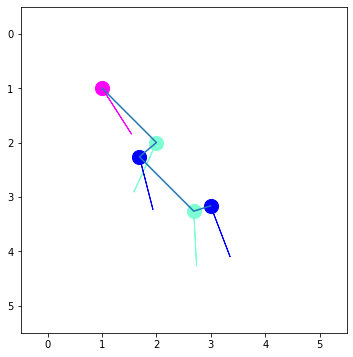

In [46]:
from KalmanFilterClass import KalmanFilterClass

#object declaration
kalmanFilter=KalmanFilterClass()

#initialisation
initialState=[1,1,1] #(x,y,théta)
kalmanFilter.setState(initialState)

#predicting
inputKalman=[1,1,1]
timeStep=1
predictedState=kalmanFilter.predict(inputKalman,timeStep)

#updating
measurement=[1.4,2.5,0.7]
updatedState=kalmanFilter.update(measurement)

#predicting 2
inputKalman=[1,1,0.2]
timeStep=1
predictedState2=kalmanFilter.predict(inputKalman,timeStep)

#updating 2
measurement=[3.2,3.1,1]
updatedState2=kalmanFilter.update(measurement)



#plotting
grid=np.zeros((6,6))
cmap = colors.ListedColormap(['white', 'grey'])
plt.figure(figsize=(6,6))
plt.imshow(grid, cmap=cmap)
plt.scatter(initialState[0], initialState[1], marker="o", color='magenta', s=200);
plt.arrow(initialState[0],initialState[1],math.cos(initialState[2]),math.sin(initialState[2]),ec='magenta')
plt.scatter(predictedState[0], predictedState[1], marker="o", color='aquamarine', s=200);
plt.arrow(predictedState[0],predictedState[1],math.cos(predictedState[2]),math.sin(predictedState[2]),ec='aquamarine')
plt.scatter(updatedState[0],updatedState[1], marker="o", color='blue', s=200);
plt.arrow(updatedState[0],updatedState[1], math.cos(updatedState[2]),math.sin(updatedState[2]),ec='blue')
plt.scatter(predictedState2[0], predictedState2[1], marker="o", color='aquamarine', s=200);
plt.arrow(predictedState2[0],predictedState2[1],math.cos(predictedState2[2]),math.sin(predictedState2[2]),ec='aquamarine')
plt.scatter(updatedState2[0],updatedState2[1], marker="o", color='blue', s=200);
plt.arrow(updatedState2[0],updatedState2[1], math.cos(updatedState2[2]),math.sin(updatedState2[2]),ec='blue')
plt.plot([initialState[0],predictedState[0],updatedState[0],predictedState2[0],updatedState2[0]],
         [initialState[1],predictedState[1],updatedState[1],predictedState2[1],updatedState2[1]])

### 5. Local Navigation <a class="anchor" id="chapter5"></a>
In the local navigation part, the `LocalNavigator.py` roles to control and run Thymio with given angle to follow the global path, avoid obstacles, and recognize a kidnapping situation.  

#### 5.1 Local Avoidance <a class="anchor" id="section_5_1"></a>
Thymio has several useful sensors to detect obstacles such as proxy sensors. The idea of the local avoidance is to consider possible cases that Thymio meets.



**1. No obstacle**
```
if any obstacles are not detected within the threshold
    FOLLOW_GLOBAL_PATH with the given angle
end

function FOLLOW_GLOBAL_PATH
    INPUT    angle
    omega <- -angle
    motor_speed <- 180 - abs(3 * omega)
    limit motor_speed into range 0 to 200
    Go forward setting as follow:
        left  motor speed <- motor_speed - omega
        right motor speed <- motor_speed + omega
end
```

**2. Front obstacle**
```
if the front middle sensor value is greater than the threshold
    if Thymio is too close to the obstacle
        Go backward
    end

    if left_sensor_val - right_sensor_val < -100    # the obstacle is close to the left side
        Turn right
    if left_sensor_val - right_sensor_val > 100     # the obstacle is close to the right side
        Turn left
    else    # parallelly
        Turn left with probability 0.05
        Turn right with probability 0.95
    end
end

```

**3. Left/Right obstacle**
```
if any of two front left sensor values is greater than the threshold
    Turn right
end

if any of two front right sensor values is greater than the threshold
    Turn left
end
```
**4. Back obstacle**
```
if any of two back sensor values is greater than the threshold
    Go forward
end
```
**5. Deadlock**
```
if Thymio continues to alternate right and left turns over 20 times
    deadlock_flag <- TRUE
else
    deadlock_flag <- FALSE
end
if deadlock_flag is TRUE
    Turn right until there is no more obstacle
end
```

To make Thymio move smoothly, we set the motor speed corresponding to the distance to obstacles. Closer obstacles are, less motor speed is set.


#### 5.2 Kidnapping <a class="anchor" id="section_5_2"></a>
The idea to detect whether Thymio is kidnapped or not is to check its proxy ground sensor (`prox.ground.reflected`) value corresponding to the distance to the ground. Closer Thymio is to the ground, greater the sensor value is.
```
if all of ground_sensor_val is less than threshold
    kidnap <- TRUE
else
    kidnap <- FALSE
end
```


 

### 6. Overall Project <a class="anchor" id="chapter6"></a>

#### 6.1 Overview <a class="anchor" id="section_6_1"></a>
#### 6.2 Main Function <a class="anchor" id="section_6_2"></a>

### 7. Conclusion<a class="anchor" id="chapter7"></a>

    




### 8. Sources <a class="anchor" id="chapter8"></a>

All sources used for the project from internet
Maybe we shouuld also talk about the session that we use from the course 




#### A* <a class="anchor" id="section_8_1"></a>
For the A* algorithm, we based ourself on the work from Andrew Jones who wrote an article on Analytics Link. His work is itself based on previous work from Christian Careaga. We made some little ajustement but the code is mostly from his work. It can be found at https://www.analytics-link.com/post/2018/09/14/applying-the-a-path-finding-algorithm-in-python-part-1-2d-square-grid .

#### Kalman Filter and Vision<a class="anchor" id="section_8_2"></a>
We used extensivly the work from L42project for our Kalman Filter and vision. He has a youtube channel with explanations of great quality and a gitHub repository where the code he uses can be found. We would like to thanks him specially for his help and ressources. We used his codes in our work.   It can be found at : 
youtube channel : https://www.youtube.com/channel/UCn09iU3hS5Fpxv0XniGv2FQ/about
GitHub repository : https://github.com/L42Project/Tutoriels